# Full images k-Nearest Neighbor

In [1]:
###### IMPORTS ######
import os
import glob
from imutils import paths
import cv2
import numpy as np
import matplotlib.pyplot as plt
from knn_classifier import kNearestNeighbor

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
###### GLOBAL VARIABLES ######
# Labels
BACKGROUND = 0
POTATO = 1
CARROT = 2
CAT_SAL = 3
CAT_BEEF = 4
BUN = 5
ARM = 6
KETCHUP = 7

# Background mask
BGD_MASK = cv2.imread('../preprocessing/bgd_mask.jpg', cv2.IMREAD_COLOR)

# Average background image
AVG_BGD_MASK = cv2.imread('../preprocessing/avg_background.jpg', cv2.IMREAD_COLOR)

# Test directories
BGD_TEST_DIR = glob.glob('../dataset3/res_still/test/background/*.jpg')
POTATO_TEST_DIR = glob.glob('../dataset3/res_still/test/potato/*.jpg')
CARROT_TEST_DIR = glob.glob('../dataset3/res_still/test/carrots/*jpg')
CAT_SAL_TEST_DIR = glob.glob('../dataset3/res_still/test/catfood_salmon/*.jpg')
CAT_BEEF_TEST_DIR = glob.glob('../dataset3/res_still/test/catfood_beef/*.jpg')
BUN_TEST_DIR = glob.glob('../dataset3/res_still/test/bun/*.jpg')
ARM_TEST_DIR = glob.glob('../dataset3/res_still/test/arm/*.jpg')
KETCHUP_TEST_DIR = glob.glob('../dataset3/res_still/test/ketchup/*.jpg')

# Train directories
BGD_TRAIN_DIR = glob.glob('../dataset3/res_still/train/background/*.jpg')
POTATO_TRAIN_DIR = glob.glob('../dataset3/res_still/train/potato/*.jpg')
CARROT_TRAIN_DIR = glob.glob('../dataset3/res_still/train/carrots/*jpg')
CAT_SAL_TRAIN_DIR = glob.glob('../dataset3/res_still/train/catfood_salmon/*.jpg')
CAT_BEEF_TRAIN_DIR = glob.glob('../dataset3/res_still/train/catfood_beef/*.jpg')
BUN_TRAIN_DIR = glob.glob('../dataset3/res_still/train/bun/*.jpg')
ARM_TRAIN_DIR = glob.glob('../dataset3/res_still/train/arm/*.jpg')
KETCHUP_TRAIN_DIR = glob.glob('../dataset3/res_still/train/ketchup/*.jpg')

In [3]:
###### FUNCTIONS ######
def time_function(func, *args):
    """ 
    Call a function, func, with args and return the time, in [s],
    that it took to execute.
    """
    
    import time
    tic = time.time()
    func(*args)
    toc = time.time()
    
    return toc - tic

def extract_hist(image, bins=(8, 8, 8)):
    """
    Extracts a 3D color histogram from the hsv color space using
    the supplied number of bins per channel.
    """

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(images=[hsv],
                        channels=[0, 1, 2],
                        mask=None,
                        histSize=bins,
                        ranges=[0, 180, 0, 256, 0, 256])

    cv2.normalize(src=hist, dst=hist)
    return hist.flatten()

def image_to_feature_vector(image, size=(32, 32)):
    """
    resize the image to a fixed size, then flatten the image into
    a list of raw pixel intensities
    """

    return cv2.resize(image, size).flatten()

def convert_label_to_number(label):
    """ Converts label to number """

    result = None
    if label == 'bgd':
        result = 0
    elif label == 'potato':
        result = 1
    elif label == 'carrot':
        result = 2
    elif label == 'beef':
        result = 3
    elif label == 'sal':
        result = 4
    elif label == 'bun':
        result = 5
    elif label == 'arm':
        result = 6
    elif label == 'ketchup':
        result = 7
    return result

def cross_val(k_choices, num_folds, X_train_folds, y_train_folds, shape):
    """ Performs cross validation """
    
    # A dictionary holding the accuracies to find the best value of k
    k_to_accuracies = {}

    # Perform k-fold cross validation to find the best value of k
    for k in k_choices:
        for j in range(num_folds):
            all_but_one_ind = [i for i in range(num_folds) if i != j]
            X_all_but_one = np.concatenate(X_train_folds[all_but_one_ind])
            y_all_but_one = np.concatenate(y_train_folds[all_but_one_ind])

            knn = kNearestNeighbor()
            knn.train(X_all_but_one, y_all_but_one)
            y_pred_k_f = knn.predict(X_train_folds[j], k)

            acc = float(sum(y_pred_k_f == y_train_folds[j])) / shape

            if k not in k_to_accuracies:
                k_to_accuracies[k] = []
            k_to_accuracies[k].append(acc)

    # Plot the raw observations
    for k in k_choices:
        accuracies = k_to_accuracies[k]
        plt.scatter([k] * len(accuracies), accuracies)

    # Plot the trend line with error bars that corresponde to standard deviation
    accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
    accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
    plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
    plt.title('Cross-validation on k')
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.show()

def print_info(X_train, y_train, X_test, y_test):
    """ Prints information """
    
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    print('Train matrix:', (X_train.nbytes / 1.0e6), 'MB')
    print('Test matrix:', (X_test.nbytes / 1.0e6), 'MB')
    print('Train data shape:', X_train.shape)
    print('Tain labels shape:', y_train.shape)
    print('Test data shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)

    ###### CREATE AND TRAIN CLASSIFIER ######
    classifier = kNearestNeighbor()
    classifier.train(X_train, y_train)

    # Test implementation
    dists = classifier.compute_distances_no_loops(X_test)
    print('Distance shape:', dists.shape)
    plt.figure(figsize=(12, 9))
    plt.imshow(dists, interpolation='none')
    plt.show()

    # Time performance
    time = time_function(classifier.compute_distances_no_loops, X_test)
    print('Time performance:', time, 'seconds')
    
    return X_train, y_train, X_test, y_test

def plot_image_samples(images):
    """ Plot some images to display the dataset """

    classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
    num_classes = len(classes)
    samples_per_class = 5
    plt.figure(figsize=(12, 9))
    for y, cls in enumerate(classes):
        idxs = [i for i, label in enumerate(y_test) if label == y]
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(images[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def multiband_threshold(img):
    """ Performs multiband thresholding """
        
    lower = (0, 65, 0)
    upper = (179, 255, 255)
    
    # Multiband thresholding
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(src=hsv, lowerb=lower, upperb=upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    return img

def smooth(img, size=(25, 25)):
    """ Performs gaussian smoothing on image """
    
    return cv2.GaussianBlur(img, size, 0)

## Full images

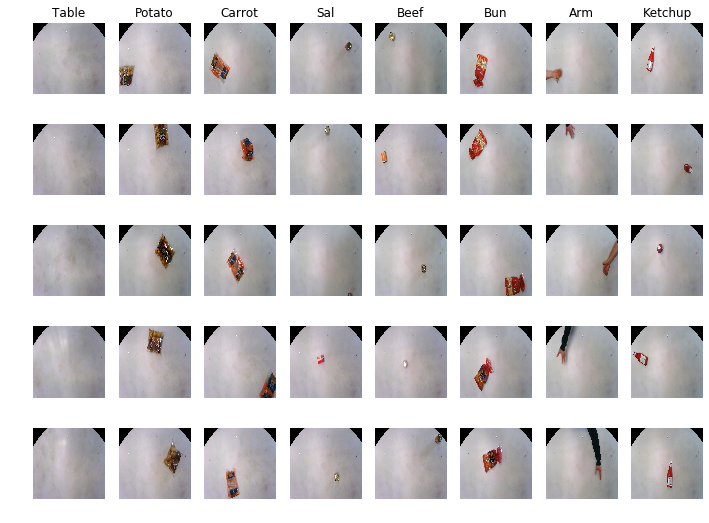

In [4]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)

        hist = extract_hist(img)
        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images
    
# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

# Visualize data
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Remove images from memory
del bgd_imgs
del potato_imgs
del carrot_imgs
del cat_sal_imgs
del cat_beef_imgs
del bun_imgs
del arm_imgs
del ketchup_imgs
del images


Information:

Train matrix: 3.84 MB
Test matrix: 0.966656 MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


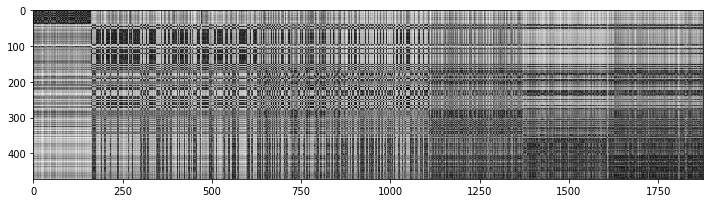

Time performance: 0.01231241226196289 seconds


In [6]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



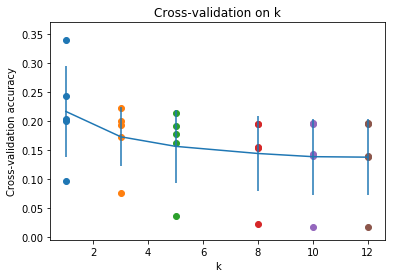

In [7]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [8]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 402 / 472 correct
Accuracy: 0.851695


In [9]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test

## Full images with gaussian smoothing

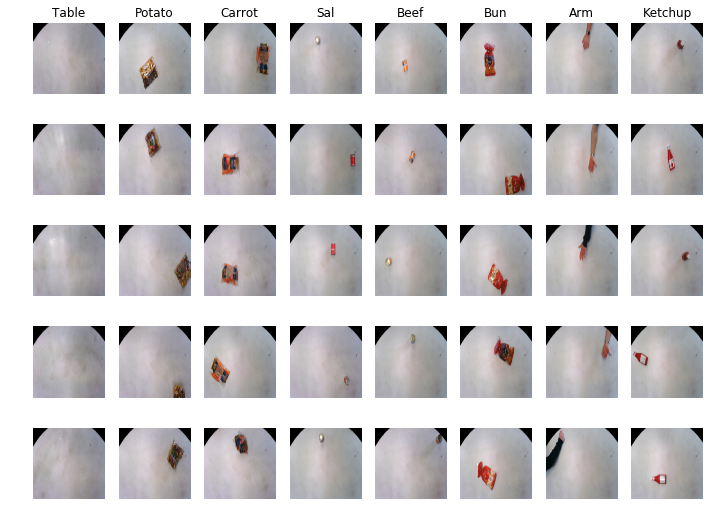

In [10]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)
        
        img = smooth(img)

        hist = extract_hist(img)
        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images
    
# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

# Visualize data
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Remove images from memory
del bgd_imgs
del potato_imgs
del carrot_imgs
del cat_sal_imgs
del cat_beef_imgs
del bun_imgs
del arm_imgs
del ketchup_imgs
del images


Information:

Train matrix: 3.84 MB
Test matrix: 0.966656 MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


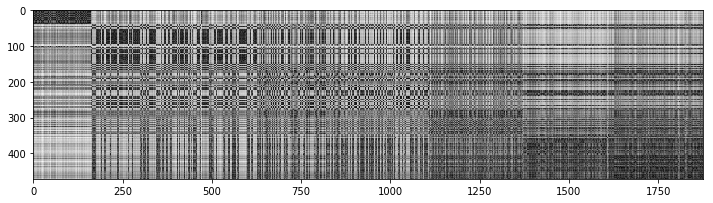

Time performance: 0.010431528091430664 seconds


In [12]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



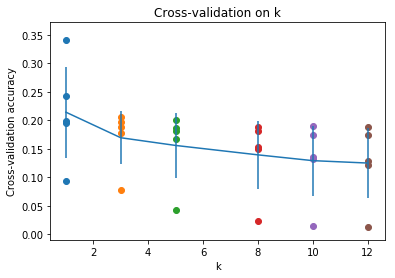

In [13]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [14]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 386 / 472 correct
Accuracy: 0.817797


In [15]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test

## Full images with multiband thresholding

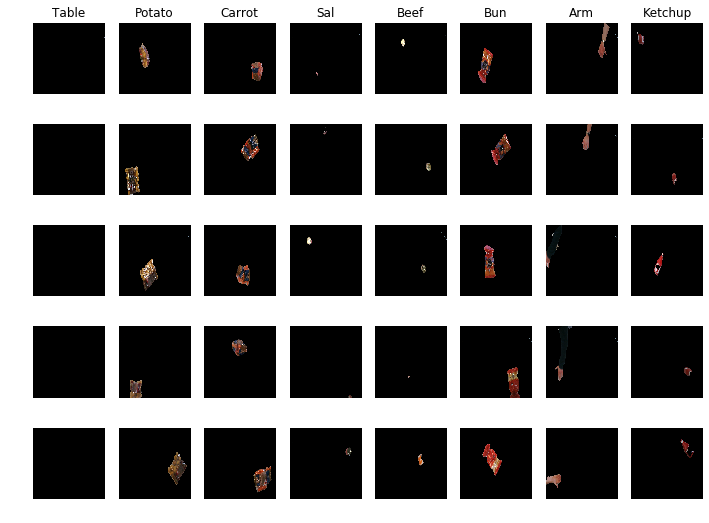

In [16]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)
        
        img = multiband_threshold(img)

        hist = extract_hist(img)
        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images
    
# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

# Visualize data
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [17]:
# Remove images from memory
del bgd_imgs
del potato_imgs
del carrot_imgs
del cat_sal_imgs
del cat_beef_imgs
del bun_imgs
del arm_imgs
del ketchup_imgs
del images


Information:

Train matrix: 3.84 MB
Test matrix: 0.966656 MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/knn/knn_classifier.py:47: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(squared_dist)


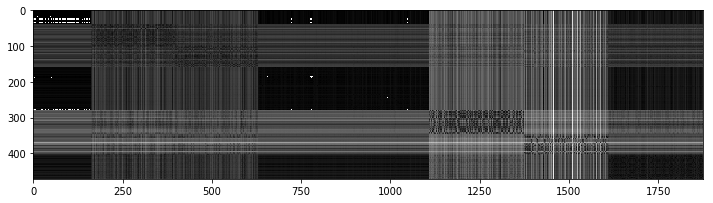

Time performance: 0.010793924331665039 seconds


In [18]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



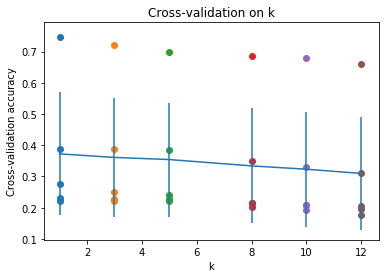

In [19]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [20]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 440 / 472 correct
Accuracy: 0.932203


In [21]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test

## Full images with gaussian smoothing and filtering

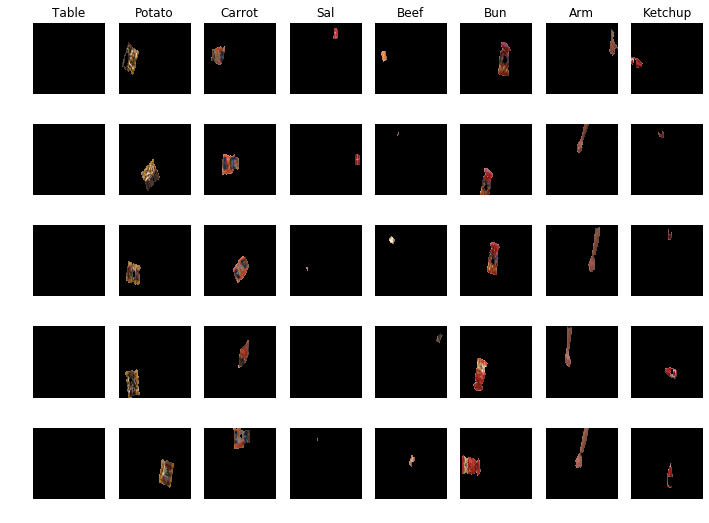

In [22]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)
        
        img = smooth(img)
        
        img = multiband_threshold(img)

        hist = extract_hist(img)
        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images
    
# Import train data
X_train = []
y_train = []

import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

# Import test data
X_test = []
y_test = []

bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

# Visualize data
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
# Remove images from memory
del bgd_imgs
del potato_imgs
del carrot_imgs
del cat_sal_imgs
del cat_beef_imgs
del bun_imgs
del arm_imgs
del ketchup_imgs
del images


Information:

Train matrix: 3.84 MB
Test matrix: 0.966656 MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


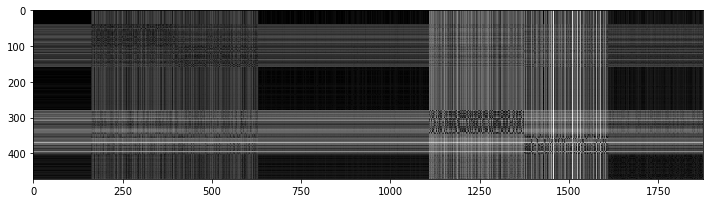

Time performance: 0.009026765823364258 seconds


In [24]:
# Informatoin
print('\nInformation:\n')
X_train, y_train, X_test, y_test = print_info(X_train, y_train, X_test, y_test)


Cross-validation:



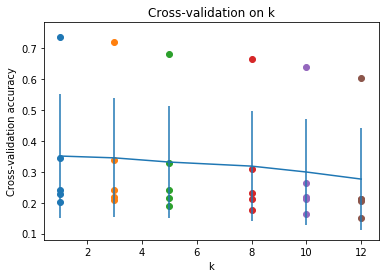

In [25]:
# Cross-validation
print('\nCross-validation:\n')

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12]

X_train_hist_folds = []
X_train_pixel_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

cross_val(k_choices, num_folds, X_train_folds, y_train_folds, X_test.shape[0])

In [26]:
# Best value of k
print('\nkNN with the best value of k:')
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('\nGot %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)


kNN with the best value of k:

Got 433 / 472 correct
Accuracy: 0.917373


In [27]:
# Remove X_train, y_train, X_test, y_test from memory
del X_train
del y_train
del X_test
del y_test